In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
! mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [2]:
# Get Titanic Dataset
!kaggle competitions download -c titanic

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 48.4MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 46.7MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.30MB/s]


In [3]:
!unzip titanic.zip
!ls -lah

unzip:  cannot find or open titanic.zip, titanic.zip.zip or titanic.zip.ZIP.
total 108K
drwxr-xr-x 1 root root 4.0K Jan 22 01:06 .
drwxr-xr-x 1 root root 4.0K Jan 22 01:04 ..
drwxr-xr-x 4 root root 4.0K Jan  7 14:33 .config
-rw-r--r-- 1 root root 3.2K Jan 22 01:06 gender_submission.csv
drwxr-xr-x 1 root root 4.0K Jan  7 14:33 sample_data
-rw-r--r-- 1 root root  28K Jan 22 01:06 test.csv
-rw-r--r-- 1 root root  60K Jan 22 01:06 train.csv


In [4]:
!pip install catboost
!pip install lightgbm
!pip install ngboost
!pip install shap

     |████████████████████████████████| 76.1 MB 1.2 MB/s 
     |████████████████████████████████| 348 kB 44.4 MB/s 
     |████████████████████████████████| 55 kB 3.7 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=2b8f040a2747a1cee63756631fd56ce168f35aad5d4b65603c0391817d6b32fa
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
     |████████████████████████████████| 564 kB 24.7 MB/s 


In [46]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Essentials
import numpy as np
import pandas as pd
import random
import time
import gc
import os
from datetime import datetime

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns
# matplotlib 의 기본 scheme 말고 
# seaborn scheme 을 세팅하여, 일일이 graph의 font size 지정할 필요 없이 
# seaborn 의 font_scale 을 사용하는 것을 추천드립니다.
plt.style.use('seaborn')
sns.set(font_scale=2.5) 
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 80,60

# Models
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from ngboost import NGBClassifier, NGBRegressor
from lightgbm.plotting import plot_importance
import lightgbm
import xgboost as xgb
import catboost
from xgboost import plot_tree

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


# Misc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from dateutil import tz
from geopy import distance
import shap

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

<Figure size 1600x800 with 0 Axes>

In [23]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [24]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다

In [25]:
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean() # testset 에 있는 nan value 를 평균값으로 치환합니다.

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

In [26]:
df_train['Initial']= df_train.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
    
df_test['Initial']= df_test.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

In [27]:
df_train['Initial'].replace(
    ['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
    ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],
    inplace=True
)

df_test['Initial'].replace(
    ['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
    ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],
    inplace=True
)

In [28]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

In [29]:
df_train['Embarked'].fillna('S', inplace=True)

In [31]:
# 장기적으로 편리한 방법
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7    
    
df_train['Age_cat'] = df_train['Age'].apply(category_age)
df_test['Age_cat'] = df_test['Age'].apply(category_age)

In [32]:
df_train.drop(['Age'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

In [33]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

In [34]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

In [35]:
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

In [47]:
def show_time(diff):
   m, s = divmod(diff, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def Train(clf, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    model = clf.fit(X,y)
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('\nPrediction time: ')
    show_time(end - start)
    return model

# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def GridSearch(clf, params, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    if(type=='classification'):
        model = GridSearchCV(clf, params, scoring='accuracy', n_jobs=-1, cv=5).fit(X,y).best_estimator_
    else:
        model = GridSearchCV(clf, params, scoring='r2', n_jobs=-1, cv=5).fit(X,y).best_estimator_
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('Prediction time: ')
    show_time(end - start)
    return model

# Takes in model scores and plots them on a bar graph
def plot_metric(model_scores, score='Accuracy'):
    # Set figure size
    rcParams['figure.figsize'] = 20,15
    plt.bar(model_scores['Model'], height=model_scores[score])
    xlocs, xlabs = plt.xticks()
    xlocs=[i for i in range(0,17)]
    xlabs=[i for i in range(0,17)]
    if(score != 'Prediction Times'):
        for i, v in enumerate(model_scores[score]):
            plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
    plt.xlabel('Model')
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()

# Takes in training data and a model, and plots a bar graph of the model's feature importances
def feature_importances(df, model, model_name, max_num_features=10):
    feature_importances = pd.DataFrame(columns = ['feature', 'importance'])
    feature_importances['feature'] = df.columns
    feature_importances['importance'] = model.feature_importances_
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances = feature_importances[:max_num_features]
    print(feature_importances)
    plt.figure(figsize=(12, 6));
    sns.barplot(x="importance", y="feature", data=feature_importances);
    plt.title(model_name+' features importance:');

# Takes in training data and a model, and plots a bar graph of SHAP values
def shap_values(df, model, model_name):
    shap_values = shap.TreeExplainer(model).shap_values(df)
    shap_values[:5]
    shap.summary_plot(shap_values, df.iloc[:1000,:])

In [37]:
print(df_train.columns)
df_train.head()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilySize', 'Initial',
       'Age_cat'],
      dtype='object')


,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Initial,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,3
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,3
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,2,3


In [40]:
df_train.shape

(891, 14)

In [41]:
X_train = df_train.loc[
    :700, ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']
]
y_train = df_train.loc[
    :700, ['Survived']
]
X_test = df_train.loc[
    700:, ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']
]
y_test = df_train.loc[
    700:, ['Survived']
]

<a href='https://postimages.org/' target='_blank'><img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_svc_0011.png' border='0' alt='image'/></a>


NgBoost Hyperparameter list up
https://github.com/stanfordmlgroup/ngboost/blob/51a299197ae77dff88826156edf386313201d99b/ngboost/api.py#L21

In [43]:
from sklearn.metrics import accuracy_score

In [44]:
prediction_times = []
training_times = []
scores = []
# training_times
# prediction_times

lin_svm = Train(LinearSVC(), X_train, y_train, X_test, y_test)
non_lin_svm = Train(SVC(kernel='rbf'), X_train, y_train, X_test, y_test)
decision_tree = Train(DecisionTreeClassifier(max_depth=5), X_train, y_train, X_test, y_test)
random_forest= Train(RandomForestClassifier(n_estimators=50,max_depth=5), X_train, y_train, X_test, y_test)
extra_trees = Train(ExtraTreesClassifier(n_estimators=50,max_depth=5), X_train, y_train, X_test, y_test)
xgboost = Train(XGBClassifier(n_estimators=50, max_depth=5), X_train, y_train, X_test, y_test)
lgb = Train(LGBMClassifier(n_estimators=50, max_depth=5), X_train, y_train, X_test, y_test)
cat = Train(CatBoostClassifier(n_estimators=50, verbose=False, max_depth=5), X_train, y_train, X_test, y_test)
ngb = Train(NGBClassifier(n_estimators=50, verbose=False, natural_gradient=False), X_train, y_train, X_test, y_test)

Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00


In [48]:
# XGBoost with GridSearch
param_grid=[{'max_depth':[5,10],
           'n_estimators':[100],
           'learning_rate':[0.05,0.1],
           'colsample_bytree':[0.8,0.95]}]
xgboost_gs = GridSearch(XGBClassifier(random_state=42), param_grid, X_train, y_train, X_test, y_test)

Training time: 
Execution Time: 00:00:03
Prediction time: 
Execution Time: 00:00:00


In [49]:
# LightGBM with GridSearch
param_grid=[{'max_depth':[5,10],
           'n_estimators':[100],
           'learning_rate':[0.05,0.1],
           'colsample_bytree':[0.8,0.95]}]
lgb_gs = GridSearch(LGBMClassifier(random_state=42), param_grid, X_train, y_train, X_test, y_test)

Training time: 
Execution Time: 00:00:01
Prediction time: 
Execution Time: 00:00:00


In [50]:
# CatBoost with GridSearch
start = time.time()
param_grid=[{'n_estimators':[10,100],
            'learning_rate':[0.05,0.1],
            'rsm':[0.5,0.8]}]
cat_gs = GridSearch(CatBoostClassifier(random_state=42, silent = True,
                        bootstrap_type = 'Bernoulli'), param_grid, X_train[:4000], y_train[:4000], X_test, y_test)

Training time: 
Execution Time: 00:00:03
Prediction time: 
Execution Time: 00:00:00


In [51]:
# NgBoost with GridSearch
start = time.time()
param_grid=[{'n_estimators':[10,100],
            'learning_rate':[0.05,0.1]}]
ngb_gs = GridSearch(NGBClassifier(random_state=42), param_grid, X_train[:4000], y_train[:4000], X_test, y_test)

[iter 0] loss=0.6679 val_loss=0.0000 scale=2.0000 norm=4.0000
Training time: 
Execution Time: 00:00:04
Prediction time: 
Execution Time: 00:00:00


In [52]:
# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def GridSearchEarlyStopping(clf, params, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()

    if(type=='classification'):
        fit_params={
            "early_stopping_rounds":10, 
            "eval_metric" : "auc", 
            "eval_set" : [[X_predict, y_predict]]
        }
        model = GridSearchCV(
            clf, params, scoring='accuracy', n_jobs=-1, cv=5
        ).fit(X,y, **fit_params).best_estimator_
    else:
        fit_params={
            "early_stopping_rounds":10, 
            "eval_metric" : 'error', 
            "eval_set" : [[X_predict, y_predict]]
        }
        model = GridSearchCV(
            clf, params, scoring='r2', n_jobs=-1, cv=5
        ).fit(X,y, **fit_params).best_estimator_
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('Prediction time: ')
    show_time(end - start)
    return model

In [53]:
# XGBoost with GridSearch with Early Stopping
param_grid=[{'max_depth':[5,10],
           'n_estimators':[100],
           'learning_rate':[0.05,0.1],
           'colsample_bytree':[0.8,0.95]}]
xgboost_gs_es = GridSearchEarlyStopping(XGBClassifier(random_state=42), param_grid, X_train, y_train, X_test, y_test)

[0]	validation_0-auc:0.908509
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.912793
[2]	validation_0-auc:0.913791
[3]	validation_0-auc:0.914378
[4]	validation_0-auc:0.912735
[5]	validation_0-auc:0.914202
[6]	validation_0-auc:0.913732
[7]	validation_0-auc:0.913028
[8]	validation_0-auc:0.912148
[9]	validation_0-auc:0.91338
[10]	validation_0-auc:0.913204
[11]	validation_0-auc:0.9152
[12]	validation_0-auc:0.914026
[13]	validation_0-auc:0.913556
[14]	validation_0-auc:0.912617
[15]	validation_0-auc:0.912852
[16]	validation_0-auc:0.913322
[17]	validation_0-auc:0.913791
[18]	validation_0-auc:0.914143
[19]	validation_0-auc:0.914319
[20]	validation_0-auc:0.913498
[21]	validation_0-auc:0.914437
Stopping. Best iteration:
[11]	validation_0-auc:0.9152

Training time: 
Execution Time: 00:00:03
Prediction time: 
Execution Time: 00:00:00


In [54]:
# LightGBM with GridSearch with Early Stopping
param_grid=[{'max_depth':[5,10],
           'n_estimators':[100],
           'learning_rate':[0.05,0.1],
           'colsample_bytree':[0.8,0.95]}]
lgb_gs_es = GridSearchEarlyStopping(LGBMClassifier(random_state=42), param_grid, X_train[:4000], y_train[:4000], X_test, y_test)

[1]	valid_0's binary_logloss: 0.641391	valid_0's auc: 0.854754
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.619855	valid_0's auc: 0.900469
[3]	valid_0's binary_logloss: 0.600157	valid_0's auc: 0.900059
[4]	valid_0's binary_logloss: 0.586094	valid_0's auc: 0.897829
[5]	valid_0's binary_logloss: 0.569699	valid_0's auc: 0.899824
[6]	valid_0's binary_logloss: 0.554737	valid_0's auc: 0.898357
[7]	valid_0's binary_logloss: 0.541135	valid_0's auc: 0.898709
[8]	valid_0's binary_logloss: 0.528905	valid_0's auc: 0.898474
[9]	valid_0's binary_logloss: 0.517403	valid_0's auc: 0.899178
[10]	valid_0's binary_logloss: 0.506646	valid_0's auc: 0.899765
[11]	valid_0's binary_logloss: 0.498837	valid_0's auc: 0.899061
[12]	valid_0's binary_logloss: 0.491818	valid_0's auc: 0.898474
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.619855	valid_0's auc: 0.900469
Training time: 
Execution Time: 00:00:01
Prediction time: 
Execution Time: 00:00:

In [59]:
def GridSearchEarlyStopping_cat_ngb(clf, params, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()

    if(type=='classification'):
        fit_params={
            "early_stopping_rounds":10, 
            # "eval_metric" : "auc", 
            # "eval_set" : [[X_predict, y_predict]]
        }
        model = GridSearchCV(
            clf, params, scoring='accuracy', n_jobs=-1, cv=5
        ).fit(X,y, **fit_params).best_estimator_
    else:
        fit_params={
            "early_stopping_rounds":10, 
            # "eval_metric" : "error", 
            # "eval_set" : [[X_predict, y_predict]]
        }
        model = GridSearchCV(
            clf, params, scoring='r2', n_jobs=-1, cv=5
        ).fit(X,y, **fit_params).best_estimator_
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('Prediction time: ')
    show_time(end - start)
    return model

In [60]:
# CatBoost with GridSearch with Early Stopping
start = time.time()
param_grid=[{'n_estimators':[10,100],
            'learning_rate':[0.05,0.1],
            'rsm':[0.5,0.8]}]
cat_gs_es = GridSearchEarlyStopping_cat_ngb(CatBoostClassifier(random_state=42, silent = True,
                        bootstrap_type = 'Bernoulli'), param_grid, X_train[:4000], y_train[:4000], X_test, y_test)

Training time: 
Execution Time: 00:00:02
Prediction time: 
Execution Time: 00:00:00


In [61]:
# NgBoost with GridSearch with Early Stopping
start = time.time()
param_grid=[{'n_estimators':[10,100],
            'learning_rate':[0.05,0.1]}]
ngb_gs_es = GridSearchEarlyStopping_cat_ngb(NGBClassifier(random_state=42), param_grid, X_train[:4000], y_train[:4000], X_test, y_test)

[iter 0] loss=0.6679 val_loss=0.0000 scale=2.0000 norm=4.0000
Training time: 
Execution Time: 00:00:04
Prediction time: 
Execution Time: 00:00:00


In [63]:
models = [
    ('LinearSVM', lin_svm),
    ('NonLinearSVM', non_lin_svm),
    ('DecisionTree', decision_tree),
    ('RandomForest', random_forest),
    ('ExtraTrees', extra_trees),
    ('XGBoost', xgboost),
    ('LightGBM', lgb),
    ('CatBoost', cat),
    ('NgBoost', ngb),
    ('XGBoost GridSearch', xgboost_gs),
    ('LightGBM GridSearch', lgb_gs),
    ('CatBoost GridSearch', cat_gs),
    ('NgBoost GridSearch', ngb_gs),
    ('XGBoost GS EarlyStopping', xgboost_gs_es),
    ('LightGBM GS EarlyStopping', lgb_gs_es),
    ('CatBoost GS EarlyStopping', cat_gs_es),
    ('NgBoost GS EarlyStopping', ngb_gs_es)
]

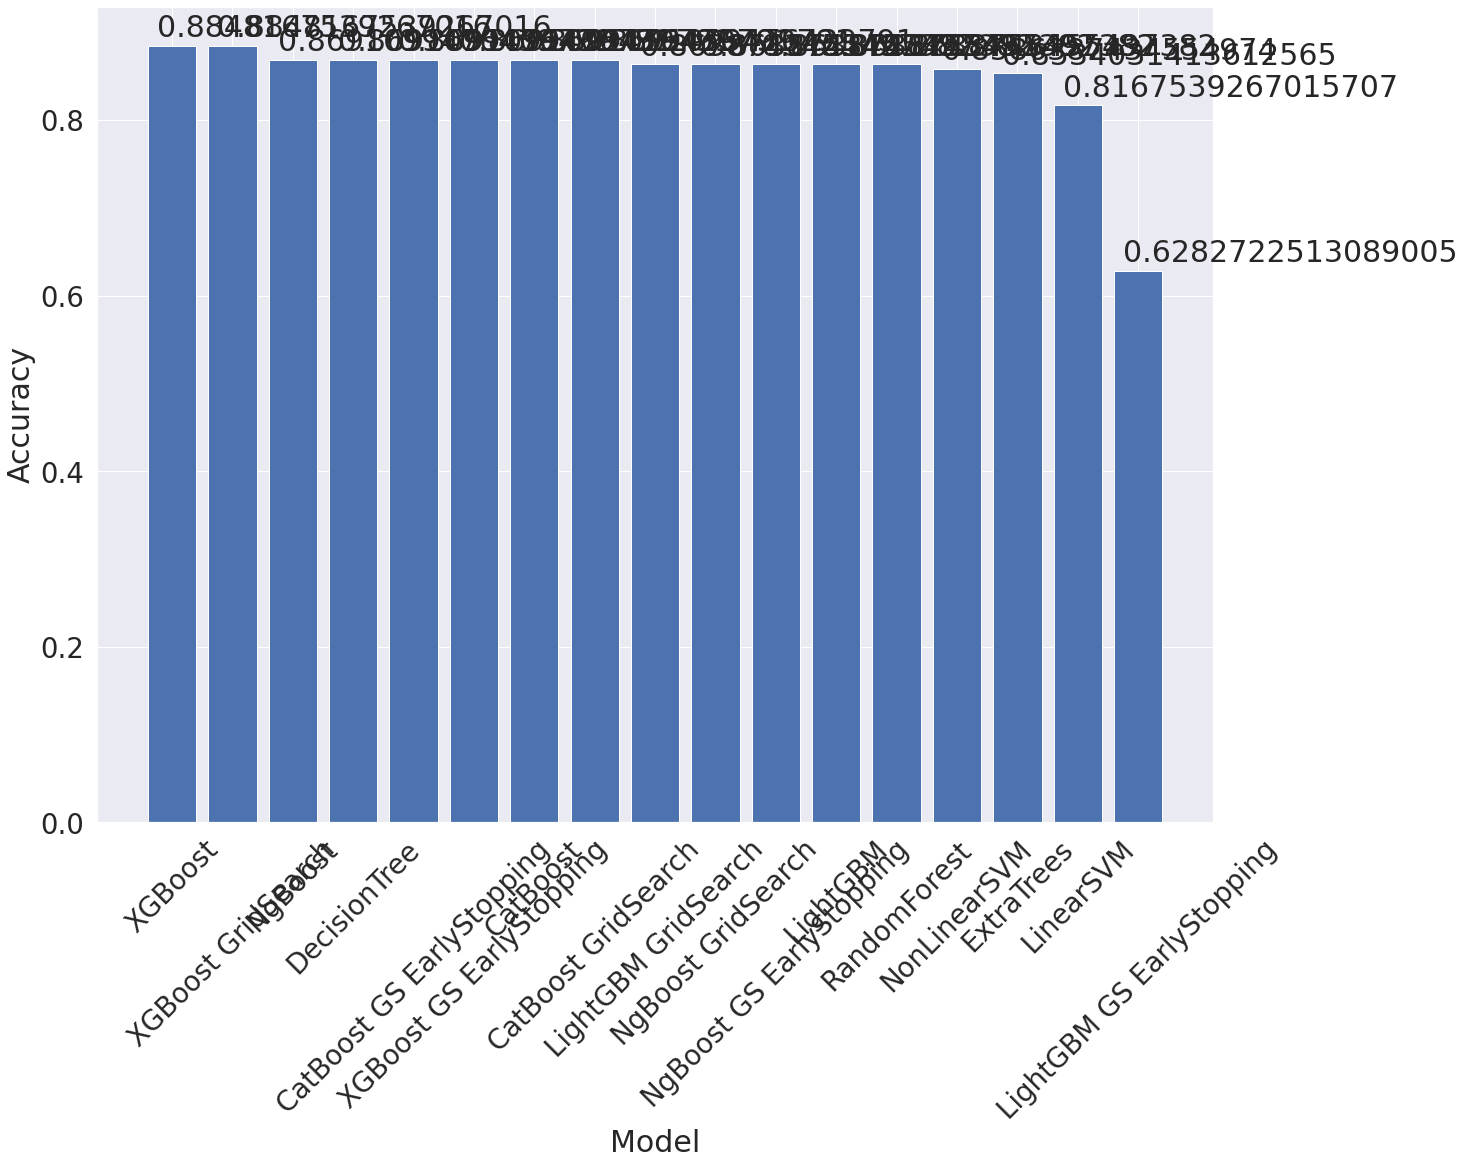

In [64]:
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'Accuracy': scores })
model_scores.sort_values(by='Accuracy',ascending=False,inplace=True)
plot_metric(model_scores, score='Accuracy')

In [ ]:
print(df_train.columns)
df_train.head()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilySize', 'Initial',
       'Age_cat'],
      dtype='object')


,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Initial,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,3
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,3
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,2,3


In [65]:
X_train_reg = df_train.loc[
    :700, ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']
]
y_train_reg = df_train.loc[
    :700, ['Fare']
]
X_test_reg = df_train.loc[
    700:, ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']
]
y_test_reg = df_train.loc[
    700:, ['Fare']
]

In [66]:
prediction_times = []
training_times = []
scores = []
# training_times
# prediction_times

reg_lin_svm = Train(LinearSVR(), X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')
reg_non_lin_svm = Train(SVR(kernel='rbf'), X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')
reg_decision_tree = Train(DecisionTreeRegressor(max_depth=5), X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')
reg_random_forest= Train(RandomForestRegressor(n_estimators=50,max_depth=5), X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')
reg_extra_trees = Train(ExtraTreesRegressor(n_estimators=50,max_depth=5), X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')
reg_xgboost = Train(XGBRegressor(n_estimators=50, max_depth=5), X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')
reg_lgb = Train(LGBMRegressor(n_estimators=50, max_depth=5), X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')
reg_cat = Train(CatBoostRegressor(n_estimators=50, verbose=False, max_depth=5), X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')
reg_ngb = Train(NGBRegressor(n_estimators=50, verbose=False, natural_gradient=False), X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')

Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00
[01:47:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00


In [67]:
# XGBoost with GridSearch
param_grid=[{'max_depth':[5,10],
           'n_estimators':[100],
           'learning_rate':[0.05,0.1],
           'colsample_bytree':[0.8,0.95]}]
reg_xgboost_gs = GridSearch(XGBRegressor(random_state=42), param_grid, X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')

# LightGBM with GridSearch
param_grid=[{'max_depth':[5,10],
           'n_estimators':[100],
           'learning_rate':[0.05,0.1],
           'colsample_bytree':[0.8,0.95]}]
reg_lgb_gs = GridSearch(LGBMRegressor(random_state=42), param_grid, X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')

# CatBoost with GridSearch
start = time.time()
param_grid=[{'n_estimators':[10,100],
            'learning_rate':[0.05,0.1],
            'rsm':[0.5,0.8]}]
reg_cat_gs = GridSearch(CatBoostRegressor(random_state=42, silent = True,
                        bootstrap_type = 'Bernoulli'), param_grid, X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')

# NgBoost with GridSearch
start = time.time()
param_grid=[{'n_estimators':[10,100],
            'learning_rate':[0.05,0.1]}]
reg_ngb_gs = GridSearch(NGBRegressor(random_state=42), param_grid, X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')

[01:48:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training time: 
Execution Time: 00:00:02
Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:01
Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:02
Prediction time: 
Execution Time: 00:00:00
[iter 0] loss=1.4194 val_loss=0.0000 scale=1.0000 norm=1.0003
Training time: 
Execution Time: 00:00:09
Prediction time: 
Execution Time: 00:00:00


In [68]:
# XGBoost with GridSearch with Early Stopping
param_grid=[{'max_depth':[5,10],
           'n_estimators':[100],
           'learning_rate':[0.05,0.1],
           'colsample_bytree':[0.8,0.95]}]
reg_xgboost_gs_es = GridSearchEarlyStopping(XGBRegressor(random_state=42), param_grid, X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')

# LightGBM with GridSearch with Early Stopping
param_grid=[{'max_depth':[5,10],
           'n_estimators':[100],
           'learning_rate':[0.05,0.1],
           'colsample_bytree':[0.8,0.95]}]
reg_lgb_gs_es = GridSearchEarlyStopping(LGBMRegressor(random_state=42), param_grid, X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')

# CatBoost with GridSearch with Early Stopping
start = time.time()
param_grid=[{'n_estimators':[10,100],
            'learning_rate':[0.05,0.1],
            'rsm':[0.5,0.8]}]
reg_cat_gs_es = GridSearchEarlyStopping_cat_ngb(CatBoostRegressor(random_state=42, silent = True,
                        bootstrap_type = 'Bernoulli'), param_grid, X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')

# NgBoost with GridSearch with Early Stopping
start = time.time()
param_grid=[{'n_estimators':[10,100],
            'learning_rate':[0.05,0.1]}]
reg_ngb_gs_es = GridSearchEarlyStopping_cat_ngb(NGBRegressor(random_state=42), param_grid, X_train_reg, y_train_reg, X_test_reg, y_test_reg, type='regression')

[01:48:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-error:-1.8474
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:-1.8474
[2]	validation_0-error:-1.8474
[3]	validation_0-error:-1.8474
[4]	validation_0-error:-1.8474
[5]	validation_0-error:-1.8474
[6]	validation_0-error:-1.8474
[7]	validation_0-error:-1.8474
[8]	validation_0-error:-1.8474
[9]	validation_0-error:-1.8474
[10]	validation_0-error:-1.8474
Stopping. Best iteration:
[0]	validation_0-error:-1.8474

Training time: 
Execution Time: 00:00:01
Prediction time: 
Execution Time: 00:00:00
[1]	valid_0's l2: 0.97965
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 0.868535
[3]	valid_0's l2: 0.780284
[4]	valid_0's l2: 0.742746
[5]	valid_0's l2: 0.677292
[6]	valid_0's l2: 0.625149
[7]	valid_0's l2: 0.583002
[8]	valid_0's l2: 0.551453
[9]	valid_0's l2: 0.537588
[10]	valid_0's l2: 

In [69]:
models = [
    ('LinearSVM', reg_lin_svm),
    ('NonLinearSVM', reg_non_lin_svm),
    ('DecisionTree', reg_decision_tree),
    ('RandomForest', reg_random_forest),
    ('ExtraTrees', reg_extra_trees),
    ('XGBoost', reg_xgboost),
    ('LightGBM', reg_lgb),
    ('CatBoost', reg_cat),
    ('NgBoost', reg_ngb),
    ('XGBoost GridSearch', reg_xgboost_gs),
    ('LightGBM GridSearch', reg_lgb_gs),
    ('CatBoost GridSearch', reg_cat_gs),
    ('NgBoost GridSearch', reg_ngb_gs),
    ('XGBoost GS EarlyStopping', reg_xgboost_gs_es),
    ('LightGBM GS EarlyStopping', reg_lgb_gs_es),
    ('CatBoost GS EarlyStopping', reg_cat_gs_es),
    ('NgBoost GS EarlyStopping', reg_ngb_gs_es)
]

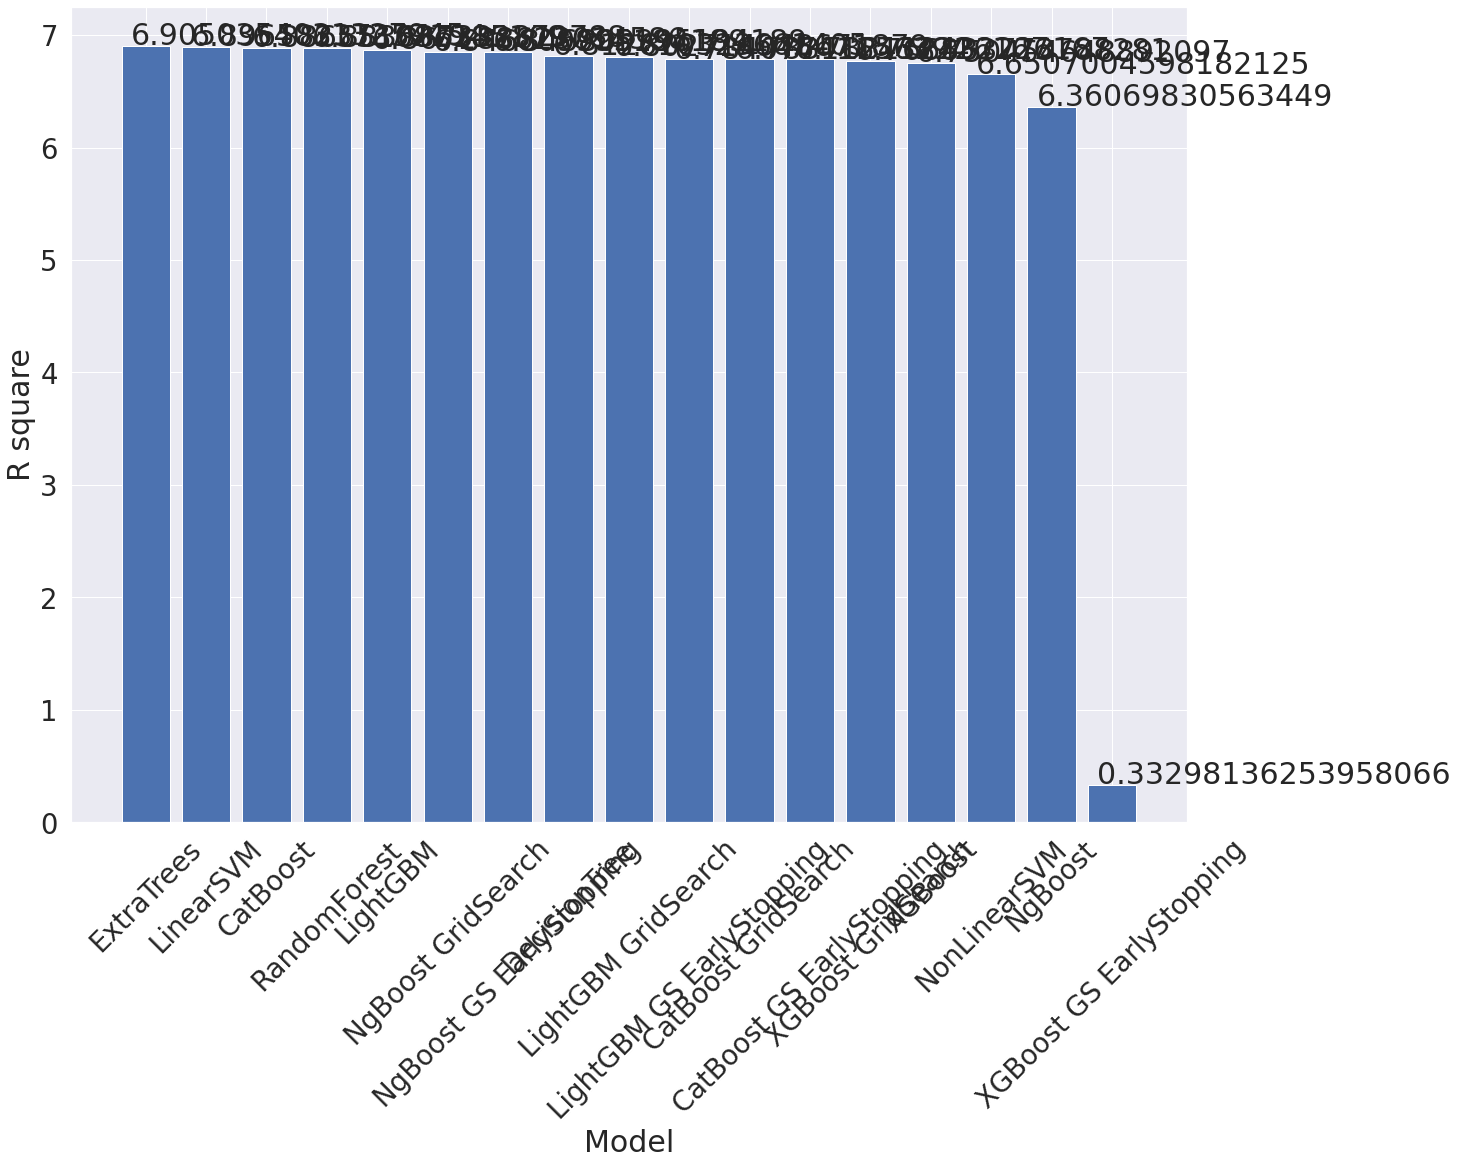

In [70]:
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'R square': scores })
model_scores.sort_values(by= 'R square',ascending=False,inplace=True)
plot_metric(model_scores, score= 'R square')